# Subsetting Speeches
---------------
``` 

Contributors:
- Elias Gabriel Heppner
- Andri Rutschmann
- Jakob Amann

***

This script handles the preprocessing of the original speeches derived from open discourse. https://opendiscourse.de/

### Loading Packages


In [1]:
import numpy as np 
import pandas as pd 
import time
import pickle
import time
import os
import datetime
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
from nltk.tokenize import word_tokenize # import tokenizer to estimate token count of a speech

C:\Users\Andri\envs\css\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Speeches Data


In [2]:
#Define 
os.chdir("../data/opendiscourse")

In [3]:
with open('speeches.pkl', 'rb') as f:
    # Load the object from the file
    speeches_df = pickle.load(f)

with open('politicians.pkl', 'rb') as f:
    # Load the object from the file
    pols_df = pickle.load(f)
    
with open('factions.pkl', 'rb') as f:
    # Load the object from the file
    facts_df = pickle.load(f)
    
with open('electoral_terms.pkl', 'rb') as f:
    # Load the object from the file
    elterms_df = pickle.load(f)
    
with open('contributions_extended.pkl', 'rb') as f:
    # Load the object from the file
   consex_df = pickle.load(f)

In [4]:
speeches_df = pd.DataFrame(speeches_df)
pols_df = pd.DataFrame(pols_df)
facts_df = pd.DataFrame(facts_df)
elterms_df = pd.DataFrame(elterms_df)   
consex_df = pd.DataFrame(consex_df)

speeches_df.head()

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date
0,0,2,1,11001150,Meine Damen und Herren! Ich eröffne die 2. Sit...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12
1,1,2,1,-1,"Der Bundesrat ist versammelt, Herr Präsident.\n",-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Guest,präsident des bundesrats,1949-09-12
2,2,2,1,11001150,Ich danke für diese Erklärung. Ich stelle dami...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12
3,3,2,1,-1,"Ja, ich habe den Wunsch.\n",-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Guest,bundespräsident,1949-09-12
4,4,2,1,11001150,Ich erteile dem Herrn Bundespräsidenten das Wo...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12


In [5]:
pols_df.head()

,id,first_name,last_name,birth_place,birth_country,birth_date,death_date,gender,profession,aristocracy,academic_title
0,11000001,Manfred,Abelein,Stuttgart,Deutschland,1930-10-20,2008-01-17,männlich,"Rechtsanwalt, Wirtschaftsprüfer, Universitätsp...",NA,Prof. Dr.
1,11000002,Ernst,Achenbach,Siegen,Deutschland,1909-04-09,1991-12-02,männlich,Rechtsanwalt und Notar,NA,Dr.
2,11000003,Annemarie,Ackermann,Parabutsch,Jugoslawien,1913-05-26,1994-02-18,weiblich,Hilfsreferentin,NA,NA
3,11000004,Else,Ackermann,Berlin,Deutschland,1933-11-06,2019-09-14,weiblich,Ärztin,NA,Dr.
4,11000005,Ulrich,Adam,Teterow,Deutschland,1950-06-09,NA,männlich,"Mathematiker, Geschäftsführer",NA,NA


In [6]:
facts_df.head()

,id,abbreviation,full_name
0,-1,not found,not found
1,0,AfD,Alternative für Deutschland
2,1,BHE,Block der Heimatvertriebenen und Entrechteten
3,2,BP,Bayernpartei
4,3,Grüne,Bündnis 90/Die Grünen


In [7]:
elterms_df.head()

,id,start_date,end_date
0,1,-641174400,-512524800
1,2,-512438400,-385516800
2,3,-385430400,-259113600
3,4,-259027200,-132710400
4,5,-132624000,-6393600


### Merge and Omit

We remove all speeches not held by politicians and select the last three electoral cycles.

In [8]:
speeches_df = speeches_df[(speeches_df["electoral_term"] == 18) | (speeches_df["electoral_term"] == 19) | (speeches_df["electoral_term"] == 20)]
speeches_df
fin_df = pd.merge(speeches_df, pols_df, left_on='politician_id', right_on='id', how='inner')
fin_df = pd.merge(fin_df, facts_df, left_on='faction_id', right_on='id', how='inner')
fin_df = fin_df[(fin_df["electoral_term"] == 18) | (fin_df["electoral_term"] == 19) | (fin_df["electoral_term"] == 20)]
fin_df = fin_df[["id_x", "session", "electoral_term", "date", "document_url", "speech_content", "politician_id", "first_name", "last_name", "faction_id",  "abbreviation", "position_short", "position_long"]]
fin_df
fin_df.to_pickle("sub_speeches.pkl")

## Remove all Contributions that are not Speeches

In [9]:
min_tokens = 300
min_speeches = 4

In [10]:
speeches = pd.read_pickle('sub_speeches.pkl')

In [20]:
# Get the most common tokens that start off a speech (takes quite a long time since it tokenizes all 100k contributions)
starting_tokens = []

for i in speeches['speech_content']:
    out = word_tokenize(str(i), language='german')
    try:
        out = out[:10]

    except:
        out = out
        
    for j in out:
        starting_tokens.append(j.lower())

starting_tokens_10 = Counter(starting_tokens)

In [21]:
starting_tokens_10.most_common(20) # We see that Kolleg and Präsi seems to be quite popular (along with herr/frau with indicates the gender of the president)

[('!', 64596),
 (',', 59188),
 ('.', 53641),
 ('herr', 37820),
 ('und', 35354),
 ('die', 31712),
 ('frau', 29993),
 ('sehr', 27508),
 ('dank', 22988),
 ('kollegen', 22292),
 ('kolleginnen', 21592),
 ('der', 21429),
 ('vielen', 21166),
 ('ich', 20544),
 ('kollege', 20281),
 ('präsident', 19640),
 ('liebe', 19595),
 ('präsidentin', 19243),
 ('–', 17822),
 ('das', 17503)]

In [12]:
# Remove all non-speeches and short stuff
regex_df_1 = speeches[speeches['speech_content'].str[:100].str.contains('Dame|Herr|Präsi|Kolleg|Frau|lieb|ehrt', regex=True, na=False)] # remove everything not starting with a greeting

regex_df_2 = regex_df_1.copy()
regex_df_2['speech_tokenized'] = regex_df_2['speech_content'].apply(word_tokenize, language='german') # tokenize all contributions
regex_df_2['tokenized_length'] = regex_df_2['speech_tokenized'].str.len()

regex_df_3 = regex_df_2[regex_df_2['tokenized_length'] > min_tokens] # remove all contributions with less than min_tokens tokens (300)
regex_df_3.reset_index(drop=True, inplace=True)

In [13]:
print(len(speeches))
print(len(regex_df_1)) # How many entries started with a supposed greeting
print(len(regex_df_3)) # How many entries have more than 300 tokens
[i for i in regex_df_3['speech_content'].sample(5)] # look at some samples (we looked at more than 5 of course! this is just so the notebook doesn't get too cluttered)

125497
86603
36899


['Frau Präsidentin! Meine sehr verehrten Damen und\n\nHerren! Für viele Menschen ist der Bau oder Kauf eines\nEigenheims ein ganz großer Traum . Darauf wird jahrelang hingearbeitet, dafür wird jahrelang gespart . Die allermeisten können das aber alleine nicht stemmen . Sie\nsind also auf einen Kredit angewiesen .\n\nAusgerechnet da, wo es um diese Kredite geht, gibt\nes viele versteckte Kosten, weil die Banken denken, dass\nsie bei dieser Gelegenheit ordentlich mitverdienen können . Weil es eben für die meisten Menschen der größte\nKauf ist, den sie im Leben tätigen, ist das Ausmaß der\nversteckten Kosten und der Verbraucherabzocke hier besonders hoch . Deswegen, denke ich, ist es völlig unstrittig, dass Häuslebauer gesetzlich besser geschützt werden\nmüssen .\n\n({0})\n\nIch finde es allerdings umso bedauerlicher - da habe\nich an zwei Punkten eine andere Einschätzung -, dass\ndie Bundesregierung an einigen Stellen im vorliegenden\nGesetzentwurf nicht die Möglichkeiten nutzt, die die 

In [15]:
regex_df_3.to_pickle('parliament_speeches.pkl')

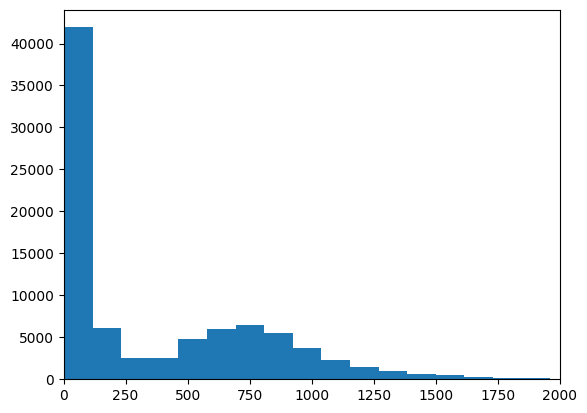

In [16]:
plt.hist(regex_df_2['tokenized_length'], bins= 100) # show that there are many short contributions (these are mostly announcements of who speaks next etc.)
plt.xlim(0, 2000)
plt.show()

In [15]:
[i for i in regex_df_2[(regex_df_2['tokenized_length'] > 100) & (regex_df_2['tokenized_length'] < 300)]['speech_content'].sample(5)] # the ones that are a bit longer are responses
# starting at 300 tokens the contributions are mostly speeches! (see sample above)

['Kollege Lenz, das war Ihre erste Rede im Deutschen\n\nBundestag. Ich gratuliere Ihnen recht herzlich und wünsche Ihnen viel Erfolg für die Zukunft.\n\n({0})\nIch gratuliere Ihnen im Übrigen aus doppeltem\nGrunde: Zum einen ist eine solche Premiere immer aufregend. Zum anderen ist Ihnen gelungen, was den wenigsten Rednern gelingt, wenn sie das erste Mal hier sprechen, nämlich die Redezeit nicht nur einzuhalten,\nsondern sogar darunter zu bleiben.\n\n({1})\n\nDas Wort hat die Kollegin Sabine Poschmann für die\nSPD-Fraktion.\n\n({2})\n\n',
 'Vielen lieben Dank, Frau Kollegin, dass Sie die Zwischenfrage gestatten. - Die Zuhörerinnen und Zuhörer\nmussten fast den Eindruck gewinnen - so befürchte ich -,\nals wollten wir Linke, dass für die Kunden das Gleiche\nwie für die Banken gelten muss, nämlich der Leitzins der\nEuropäischen Zentralbank, der derzeit bei 0,25 Prozent\nliegt. Deswegen ist meine Frage: Haben Sie zur Kenntnis genommen, dass wir als Linke nicht fordern, diesen\neins zu eins

## Removing non-topic Speeches

In [17]:
fin_df = pd.read_pickle('parliament_speeches.pkl')

In [18]:
# # regex pattern to match speeches about the war on Ukraine
pattern_ukraine_war = r'(?i)\b(Krieg|Konflikt|Invasion|Krise|Angriffskrieg|conflict|crisis)\b.*\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b|\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b.'
matches_ukraine_war = fin_df['speech_content'].str.contains(pattern_ukraine_war, case=False, flags=re.IGNORECASE)
ukraine_war_speeches = fin_df[matches_ukraine_war]
print(len(ukraine_war_speeches))


# now Covid
pattern_covid = r'(?i)\b(COVID-19|Coronavirus|Pandemie|SARS-CoV-2|Quarantäne|Lockdown|Social Distancing|Ausgangsbeschränkung(en)?|Maskenpflicht|Impfpass|Corona-Virus|Infektion(en)?|Gesundheitsnotstand|Impfpflicht)\b'
matches_covid = fin_df['speech_content'].str.contains(pattern_covid, case=False, flags=re.IGNORECASE)
covid_speeches = fin_df[matches_covid]
print(len(covid_speeches))

# now Migration 
pattern_migration = r'(?i)\b(Flüchtlinge?|Migration|Asylbewerber?|Geflüchtete?|Asylverfahren|Einwanderer?|Auswanderer?|Immigrant(en)?|Emigrant(en)?|Zuwanderer?|Vertriebene?|Schutzsuchende?|Migranten?|Asylrecht|Grenzübergang|Visapolitik|Einreiseverbot)\b'
matches_migration = fin_df['speech_content'].str.contains(pattern_migration, case=False, flags=re.IGNORECASE)
migration_speeches = fin_df[matches_migration]
print(len(migration_speeches))

C:\Users\Andri\AppData\Local\Temp\ipykernel_19240\4280228981.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_ukraine_war = fin_df['speech_content'].str.contains(pattern_ukraine_war, case=False, flags=re.IGNORECASE)


3094


C:\Users\Andri\AppData\Local\Temp\ipykernel_19240\4280228981.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_covid = fin_df['speech_content'].str.contains(pattern_covid, case=False, flags=re.IGNORECASE)


2913


C:\Users\Andri\AppData\Local\Temp\ipykernel_19240\4280228981.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_migration = fin_df['speech_content'].str.contains(pattern_migration, case=False, flags=re.IGNORECASE)


4247


In [19]:
ukraine_war_speeches.to_pickle('ukraine_war_speeches.pkl')
covid_speeches.to_pickle('covid_speeches.pkl')
migration_speeches.to_pickle('migration_speeches.pkl')